## Part 1: Network Training

### Step0: Import Package & Hyperparameter Configuration

In [10]:
%reset -f

import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 1000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002
    LR_SCHEDULER_GAMMA = 0.99
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [12]:
material = "N87"

# 定義保存模型的路徑
model_save_dir = "./Model/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step1: Data processing and data loader generate 

In [13]:
# %% Preprocess data into a data loader
def get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, norm, n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_H : np.array
        Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
    train_loader, valid_loader, test_loader : DataLoader
        Dataloaders for training, validation, and testing sets.
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = 128
    cols = range(0, 1024, int(1024 / seq_length))  #range(start, stop, step)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack((data_H, data_H[:, :n_init]))  #*(Date:241216)

    # 3. Format data into tensors
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length,
                                      1).float()  #*(Date:241216)
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 4. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]
    out_H = (H - norm[1][0]) / norm[1][1]
    in_T = (T - norm[3][0]) / norm[3][1]
    in_F = (F - norm[2][0]) / norm[2][1]
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]

    # 5. Extra features
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 6. Create dataloader to speed up data processing
    test_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H  # 目標值 H（128 點）
    )

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=Config.BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0,
                                              collate_fn=filter_input,
                                              drop_last=False)

    return test_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])

    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(features)[:, :2]

    # 保留目標值 H
    # target_H = torch.stack(target_H)  # H 的目標值（128 點）

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0

In [14]:
# %%
# Material normalization data (1.B 2.H 3.F 4.T 5.dB/dt 6.Pv)
normsDict = {
    "N87": [
        [-0.0039005703292787075, 0.060377106070518494],
        [-0.5195177793502808, 11.593074798583984],
        [5.180987358093262, 0.2678092122077942],
        [58.85100173950195, 24.114748001098633],
        [0.24289657175540924, 2.2880825996398926],
        [4.625202178955078, 0.8005720973014832],
    ]
}

#============ 500筆資料 =====================================
# "3C90": [
#     [-0.003732438897714019, 0.06363685429096222],
#     [-0.5238409042358398, 12.113346099853516],
#     [5.202671527862549, 0.27139726281166077],
#     [57.650001525878906, 23.8655948638916],
#     [0.2754420042037964, 2.469468832015991],
#     [4.579432964324951, 0.7841768264770508],
# ]

# "N49": [
#     [-0.0058940742164850235, 0.08247682452201843],
#     [-2.1639113426208496, 34.18832015991211],
#     [5.254600524902344, 0.30722910165786743],
#     [59.599998474121094, 23.514801025390625],
#     [0.34892457723617554, 3.222639322280884],
#     [5.089588642120361, 0.795062780380249],
# ]

#============ 1000筆資料======================================
# "3C90": [[-0.003862580982968211, 0.06338277459144592],
#          [-0.5482863783836365, 12.095848083496094],
#          [5.200986385345459, 0.27532079815864563],
#          [58.83000183105469, 24.202621459960938],
#          [0.27001139521598816, 2.4852683544158936],
#          [4.584597587585449, 0.788435161113739]]

#============ 3000筆資料======================================
# "N49": [[-0.005516197998076677, 0.08231832087039948],
#         [-1.9937044382095337, 34.24552536010742],
#         [5.2593913078308105, 0.3058309555053711],
#         [59.68166732788086, 24.48516845703125],
#         [0.3491934537887573, 3.211207628250122],
#         [5.080729007720947, 0.7659001350402832]]


### Step2: Define Network Structure

In [15]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
    - var_size: number of supplenmentary variables (1.F 2.T)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):
    def __init__(self,
                 Material,
                 hidden_size=Config.HIDDEN_SIZE,
                 operator_size=Config.OPERATOR_SIZE,
                 input_size=3,
                 var_size=2,
                 output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 2, 1)
        self.rnn2 = EddyCell(4, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)
        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
          - var(batch,var_size): Supplementary inputs (1.F 2.T)
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        B = (x[:, n_init:, 0:1] * self.norm[0][1] + self.norm[0][0])
        H = (output[:, n_init:, :] * self.norm[1][1] + self.norm[1][0])
        Pcv = torch.trapz(H, B, axis=1) * (10**(var[:, 0:1] * self.norm[2][1] +
                                                self.norm[2][0]))

        # ------------------Debug------------------------------------------------
        # print("Ver2 H min/max:", H.min().item(), H.max().item())
        # print("Ver2 B min/max:", B.min().item(), B.max().item())
        # print("Ver2 Pcv min/max:", Pcv.min().item(), Pcv.max().item())
        # ------------------Debug END------------------------------------------------

        return torch.flatten(Pcv)


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden

### Step3: Training the Model

In [16]:
# Load Data
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/B_Field.csv"
    in_file2 = f"{base_path}{material}/Frequency.csv"
    in_file3 = f"{base_path}{material}/Temperature.csv"
    in_file4 = f"{base_path}{material}/H_Field.csv"
    in_file5 = f"{base_path}{material}/Volumetric_Loss.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N by 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N by 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N by 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N by 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N by 1

    # 隨機選取 100 筆資料
    data_size = len(data_B)
    np.random.seed(Config.SEED)  # 設定隨機種子確保可復現
    indices = np.random.choice(data_size, 100, replace=False)  # 隨機選取 100 筆

    # 根據選取的索引提取資料
    selected_B = data_B[indices]
    selected_F = data_F[indices]
    selected_T = data_T[indices]
    selected_H = data_H[indices]
    selected_Pcv = data_Pcv[indices]

    # **將選取的索引與 Pcv 存入 DataFrame**
    df = pd.DataFrame({'Index': indices, 'Pcv': selected_Pcv.flatten()})

    # **將 DataFrame 匯出為 CSV**
    output_path = f"./Output/{material}_measured.csv"
    df.to_csv(output_path, index=False,
              header=False)  # `index=False` 避免 pandas 產生額外索引
    print(f"取出的資料已匯出至 {output_path}")

    return selected_B, selected_F, selected_T, selected_H, selected_Pcv


In [17]:
def test_model(test_loader, measured_Pcv):
    """
    Parameters
    ----------
    test_loader : DataLoader
        測試集資料加載器。
    """
    model = MMINet(Material=material).to(device)
    # 加載已訓練模型的權重
    model.load_state_dict(torch.load(model_save_path))
    model.eval()  # 設置模型為評估模式

    yy_pred_list = []

    with torch.no_grad():
        for inputs, features, s0 in test_loader:
            # 將資料移至裝置
            inputs, features, s0 = inputs.to(device), features.to(
                device), s0.to(device)

            #*------------------Debug------------------
            # #顯示 s0
            # print(f"s0 shape = {s0.shape}")
            # # print(f"s0 values = \n{s0.cpu().numpy()}")
            # print("s0 min:", torch.min(s0).item(), "s0 max:", torch.max(s0).item())

            #*------------------Debug END------------------

            # 模型預測
            yy_pred = model(inputs, features, s0)

            # 收集預測值
            yy_pred_list.append(yy_pred.cpu().numpy())

    # 將所有批次的預測值轉為 numpy 格式
    yy_pred = np.concatenate(yy_pred_list, axis=0)

    measured_Pcv = measured_Pcv[:yy_pred.shape[0]]

    # Relative Error
    Error_re = abs(yy_pred - measured_Pcv) / abs(measured_Pcv) * 100
    Error_re_avg = np.mean(Error_re)
    Error_re_95prct = np.percentile(Error_re, 95)
    Error_re_99prct = np.percentile(Error_re, 99)
    Error_re_max = np.max(Error_re)
    Error_re_min = np.min(Error_re)

    print(f"Relative Error: {Error_re_avg:.8f}")
    print(f"AVG Error: {Error_re_avg:.8f}")
    print(f"95-PRCT Error: {Error_re_95prct:.8f}")
    print(f"99th Percentile Error: {Error_re_99prct:.8f}")
    print(f"MAX Error: {Error_re_max:.8f}")
    print(f"MIN Error: {Error_re_min:.8f}")

    plt.figure(figsize=(10, 5))
    plt.plot(yy_pred, label="Predicted Pcv", linestyle="-")
    plt.plot(measured_Pcv, label="Actual Pcv", linestyle="--")
    plt.legend()
    plt.xlabel("Test Samples")
    plt.ylabel("Pcv")
    plt.title("Comparison of Predicted and Actual Core Loss")
    plt.show()

    # 將結果存入 DataFrame
    df = pd.DataFrame(yy_pred)
    # 將 DataFrame 匯出為 CSV
    output_path = f"./Output/{material}_predictions.csv"
    df.to_csv(output_path, index=False, header=False)
    print(f"預測結果已匯出至 {output_path}")

取出的資料已匯出至 ./Output/N87_measured.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_46596\1091485396.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Relative Error: 9.63777522
AVG Error: 9.63777522
95-PRCT Error: 22.75519423
99th Percentile Error: 37.29697064
MAX Error: 42.18430849
MIN Error: 0.08014471


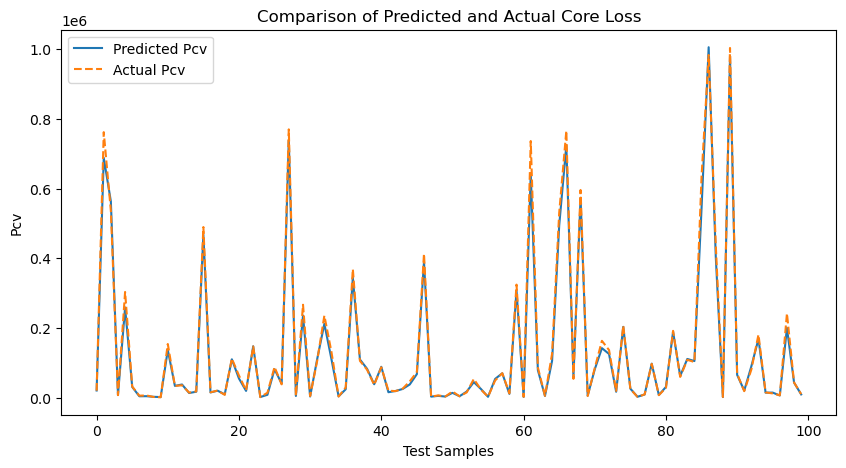

預測結果已匯出至 ./Output/N87_predictions.csv


In [18]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv = load_dataset(material)

    norm = normsDict[material]

    test_loader = get_dataloader(data_B, data_F, data_T, data_H, data_Pcv,
                                 norm)
    # 將原始的 Pcv 傳入
    test_model(test_loader, data_Pcv)